# Simulating hydrogel-based materials

This tutorial will cover
* Defining a hydrogel model and the osmotic pressure
* Defining hydration experiments to compute freely swollen states
* Running time-dependent simulations with hydrogels



## Introduction

Hydrogels are commonly used materials in biomedical applications.  Hydrogels differ from poroelastic materials in that there are strong molecular interactions between the interstitial fluid and the solid skeleton (which for a hydrogel is a polymer network).  These interactions lead to an osmotic pressure (or osmotic stress).  This osmotic pressure is responsible for a hydrogel absorbing fluid from its surrounding and swelling until chemical and mechanical equilibrium is established.  When fully swollen, the elastic stresses in a hydrogel will not be zero as the polymer network will have stretched out to accommodate new fluid.  

In [1]:
import ucompress as uc
import matplotlib.pyplot as plt

## Example 1 - Defining a hydrogel material

Defining a hydrogel material requires an extended parameter set compared to poroelastic materials.  There are two new parameters that need to be defined.  The first is the thermal stiffness $G_T = k_B T / V_m$, where $R_g$ is the universal gas constant, $T$ is temperature (in Kelvin), and $V_m$ is the molar volume of the fluid that swells the polymer matrix.  The second is the Flory interaction parameter $\chi$.  There is an example parameter set for a hydrogel in which these parameters are defined (assuming water swells the hydrogel and the temperature is 23 C):

In [2]:
pars = uc.parameters.example_parameters.Hydrogel()
print(pars)

Dimensional parameter values
---------------------------------------
R = 5.00e-03
E_m = 5.00e+04
nu_m = 0.00e+00
k_0 = 2.00e-13
G_T = 1.37e+08
chi = 5.00e-01
beta_r = 1.00e+00
beta_z = 1.00e+00
phi_0 = 0.00e+00
F = -1.00e+00
lam_z = 5.00e-01
t_start = 1.00e-02
t_end = 1.00e+04

Computational parameter values
-----------------------------------------
N = 40
Nt = 100
t_spacing = log



Importantly, the parameters above indicate that the initial porosity $\phi_0$ is **zero** and there are no pre-stretches due to hydration (these pre-stretches correspond to $\beta_r$ and $\beta_z$).  These parameters will be computed in Example 2.

There are now three components to the model: the mechanics, the permeability, and now the osmotic pressure.  In `ucompress`, an osmotic pressure based on the Flory-Huggins theory of solvent-polymer mixtures as been implemented.  We can therefore define a neo-Hookean hydrogel material with constant permeability as follows:

In [3]:
# Define the model
mech = uc.mechanics.NeoHookean()
perm = uc.permeability.Constant()
os = uc.osmosis.FloryHuggins()

# Build the model
model = uc.base_models.Hydrogel(mech, perm, os, pars)

Note the use of the `Hydrogel` class rather than the `Poroelastic` class.

## Example 2 - Computing the freely swollen (hydrated) state

Before carrying out a time-dependent simulation or computing the instantaneous/equilibrum response, we need to calculate the freely swollen (or hydrated) state.  This is because the governing equations are defined in such a way that deformations are measured relative to freely swollen states.

The freely swollen state can be calculated by defining a hydration experiment and then solving for the steady response:

In [4]:
# Define the hydration experiment 
problem = uc.experiments.Hydration(model, pars)

# Solve for the equilibrium state of a freely swollen (hydrated) hydrogel
beta_r, beta_z, phi_0 = problem.steady_response()

----------------------------------------
Hydration step
Solver converged
Volumetric expansion due to hydration: 18.0037
Fluid fraction in hydrated state: 0.9445
Radial stretch: 2.6209
Axial stretch:  2.6209


The `steady_response` method computes and returns the radial and axial stretches due to hydration, $\beta_r$ and $\beta_z$ respectively, and the porosity of the hydrogel when freely swollen $\phi_0$.

We now update the entries in the parameter set using these newly computed values.  We then assign the updated parameter set to the model

In [5]:
# Update parameter values associated with the hydrated state
pars.update('beta_r', beta_r)
pars.update('beta_z', beta_z)
pars.update('phi_0', phi_0)

# Assign new parameters to the model
model.assign(pars)

## Example 3 - Unconfined compression of a swollen hydrogel

Now that we have computed the freely swollen state and updated the parameter values, we can now simulate unconfined compression experiments.  The procedure follows that used for poroelastic materials.  For example, the code below runs a force-controlled experiment:

--------------------------------
Transient step
Solver converged
Average number of Newton iterations per time step: 2.9


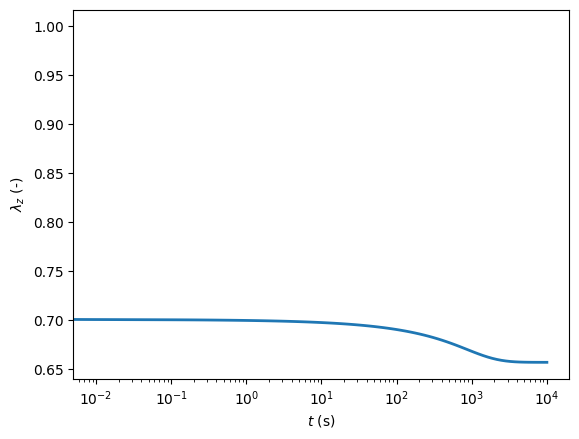

In [6]:
# Create a force-controlled experiment
problem = uc.experiments.ForceControlled(model, pars)

# Increase the convergence tolerance
solver_opts = problem.solver_opts
solver_opts['rel_tol'] = 1e-6

# Solve
sol = problem.transient_response()

# Plot
plt.semilogx(sol.t, sol.lam_z, lw = 2)
plt.xlabel('$t$ (s)')
plt.ylabel(r'$\lambda_z$ (-)')
plt.show()